In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, cross_val_score, KFold
import seaborn as sns
import sys
from sklearn.svm import SVC
import statistics
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
import matplotlib.pyplot as plt

# Defining function train_model

In [2]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = SVC(kernel='linear', random_state=42)
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
    }
    param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': [1, 0.1, 0.01, 0.001], 
    'kernel': ['linear', 'rbf']
    }

    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train)
    kFold = KFold(n_splits=10, shuffle=True, random_state=42)
    results = cross_validate(estimator=model, X=X, y=y, cv=kFold, scoring=scoring)
    predictions=best_model.predict(X_test)
    return results, predictions, model, y_test

# Main code

In [3]:
#Read dataset
df = pd.read_csv(r'output_combined.csv')
#Prep the dataset
df = df.dropna()
df = df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.dayofyear
df = df.drop(df.index[-1])
replacement_dict = {'non':0, 'NPF':1, 'undefined':2}
df['day.tpe'] = df['day.type'].replace(replacement_dict)
df_orig = df

# Iteration 1

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471

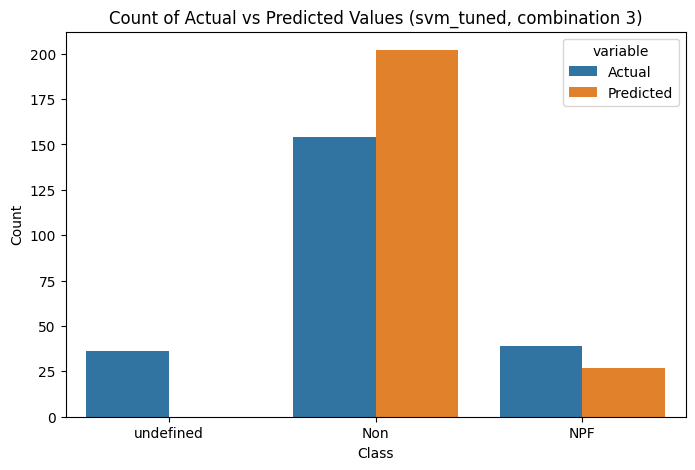

In [4]:
#Split dataset
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4", "NH4", "SO2"]].copy()
df = df_selected
X = df.drop(columns = 'day.type')
y = df['day.type']
#Unpack results
results, predictions, model, y_test = train_model(X=X, y=y)

#Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])

#Redirect stdput to file
with open('svm_tuned_combination_3.txt', 'w') as file:
    sys.stdout = file
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__
    
df_show = pd.DataFrame({'Actual':y_test.tolist(), 'Predicted':predictions.tolist()})

plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (svm_tuned, combination 3)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('svm_tuned_combination_3.png', dpi=300)

# Iteration 2

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471

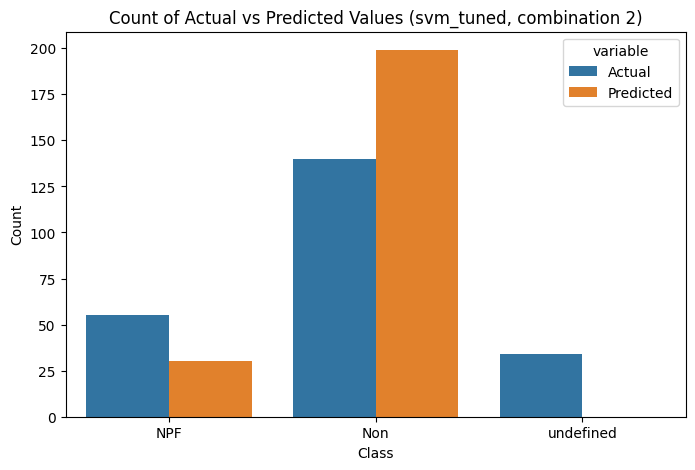

In [5]:
#Split dataset
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4"]].copy()
df = df_selected
X = df.drop(columns = 'day.type')
y = df['day.type']
#Unpack results
results, predictions, model, y_test = train_model(X=X, y=y)

#Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])

#Redirect stdput to file
with open('svm_tuned_combination_2.txt', 'w') as file:
    sys.stdout = file
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__
    
df_show = pd.DataFrame({'Actual':y_test.tolist(), 'Predicted':predictions.tolist()})

plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (svm_tuned, combination 2)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('svm_tuned_combination_2.png', dpi=300)

# Iteration 3

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471

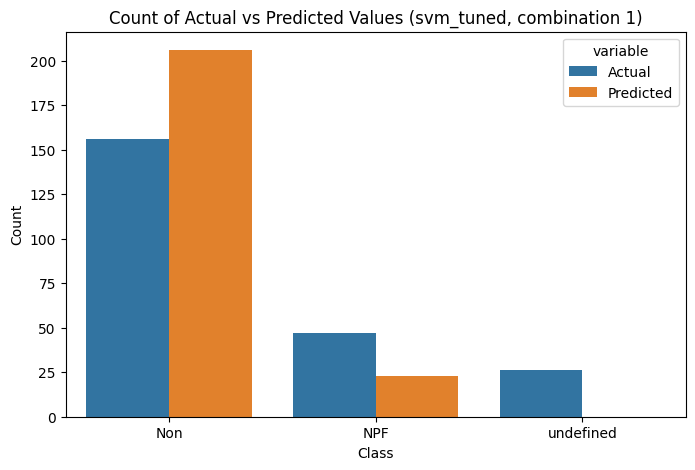

In [6]:
#Split dataset
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type"]].copy()
df = df_selected
X = df.drop(columns = 'day.type')
y = df['day.type']
#Unpack results
results, predictions, model, y_test = train_model(X=X, y=y)

#Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])

#Redirect stdput to file
with open('svm_tuned_combination_1.txt', 'w') as file:
    sys.stdout = file
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__
    
df_show = pd.DataFrame({'Actual':y_test.tolist(), 'Predicted':predictions.tolist()})

plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (svm_tuned, combination 1)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('svm_tuned_combination_1.png', dpi=300)